In [1]:
import numpy as np
import sys
sys.path.append('/home2/ebrahim/beyond-brainscore/analyze_results/figures_code')
from trained_untrained_results_funcs import find_best_layer, loop_through_datasets
import itertools
from matplotlib import pyplot as plt

In [2]:
def stack_combinations(input_dict, exclude_pairs=None, merge_sizes=None):
    
    """
    Stacks every combination of numpy arrays in the input dictionary and creates two dictionaries.
    
    Parameters:
    input_dict (dict): Dictionary where keys are strings and values are numpy arrays.
    exclude_pairs (list of tuples): List of pairs of keys that should not be stacked together.
    merge_sizes (list of tuples): List of pairs of keys whose sizes should be combined into a single value.
    
    Returns:
    tuple:
        - A dictionary with keys as combinations of the original keys and values as stacked arrays.
        - A dictionary with the same keys, but values are lists of the sizes of the concatenated arrays,
          with specified pairs having their sizes combined.
    """
    
    if exclude_pairs is None:
        exclude_pairs = []
    if merge_sizes is None:
        merge_sizes = []

    # Normalize the exclude_pairs and merge_sizes to ensure order doesn't matter
    exclude_pairs = {tuple(sorted(pair)) for pair in exclude_pairs}
    merge_sizes = {tuple(sorted(pair)) for pair in merge_sizes}
    
    output_dict = {}
    size_dict = {}
    keys = list(input_dict.keys())
    
    # Generate all combinations of keys (at least 2 keys in a combination)
    for r in range(1, len(keys) + 1):
        for combination in itertools.combinations(keys, r):
            # Check if any excluded pair exists in the combination
            skip_combination = False
            for pair in itertools.combinations(combination, 2):
                if tuple(sorted(pair)) in exclude_pairs:
                    skip_combination = True
                    break
            
            if skip_combination:
                continue
            
            # Stack the corresponding arrays
            arrays = [input_dict[key] for key in combination]
            stacked_array = np.hstack(arrays)
            
            # Create a new key by joining the original keys with '+'
            new_key = '+'.join(combination)
            output_dict[new_key] = stacked_array
            
            # Record the sizes of the concatenated arrays
            sizes = []
            merged_keys = set()
            
            for i, key1 in enumerate(combination):
                if key1 in merged_keys:
                    continue
                size = input_dict[key1].shape[1]
                
                # Check if this key should be merged with another
                for key2 in combination[i+1:]:
                    if tuple(sorted((key1, key2))) in merge_sizes:
                        size += input_dict[key2].shape[1]
                        merged_keys.add(key2)
                
                merged_keys.add(key1)
                sizes.append(size)
            
            size_dict[new_key] = sizes
    
    return output_dict, size_dict

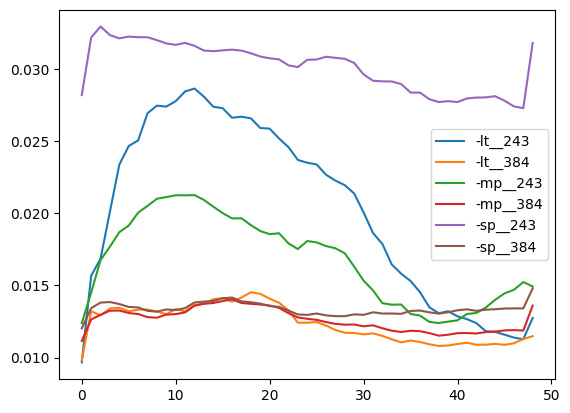

In [3]:
X_synt_dict = {}
X_synt_dict_same_layer = {}

for dataset, fe, exp, subjects, network in loop_through_datasets(['pereira'], ['', '-mp', '-sp']):
    
    lang_indices = np.argwhere(network=='language').squeeze()
    
    X_syntax = np.load(f'/data/LLMs/data_processed/pereira/acts/X_gpt2xl-syntax{fe}.npz')
    
    if fe == '':
        fe_str = '-lt'
    else:
        fe_str = fe

    layer_perf_dict, best_layer, layer_perf_best  = find_best_layer(np.arange(49), noL2_str='', 
                    exp=exp, resultsPath='/data/LLMs/brainscore/results_pereira/', subjects=subjects, 
                    dataset='pereira', perf='out_of_sample_r2', 
                    selected_network_indices = lang_indices, 
                    feature_extraction = '', model_name=f'gpt2xl-syntax{fe}', 
                    seed_number=None, 
                    return_SE=False, niter=1)
    
    syntax_best_layer = X_syntax[f'layer_{best_layer}']
    
    X_synt_dict[f"{fe}_{exp}"] = syntax_best_layer
    
    plt.plot(layer_perf_dict.keys(), layer_perf_dict.values(), label=f"{fe_str}_{exp}")

plt.legend()
plt.show()

In [4]:
best_gpt2xl_layer_dict = np.load('/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/best_layer_sigma_info/best_gpt2xl_layer.npz')

In [5]:
pereira_pos_WN_model = np.load("/data/LLMs/data_processed/pereira/acts/X_positional_WN.npz")['layer1']
pereira_pos_model = np.load("/data/LLMs/data_processed/pereira/acts/X_positional_simple.npz")['layer1']
pereira_WN_model = np.load("/data/LLMs/data_processed/pereira/acts/X_word-num.npz")['layer1']
pereira_glove_sp = np.load("/data/LLMs/data_processed/pereira/acts/X_glove-sp.npz")['layer_0']
pereira_glove_mp = np.load("/data/LLMs/data_processed/pereira/acts/X_glove-mp.npz")['layer_0']
pereira_all_simple_models = {'pos': pereira_pos_model, 'WN': pereira_WN_model}

fedorenko_WP_model = np.load("/data/LLMs/data_processed/fedorenko/acts/X_pos.npz")['layer_4.7']
fedorenko_all_simple_models = {'WP': fedorenko_WP_model}

blank_pos_model = np.load("/data/LLMs/data_processed/blank/acts/X_POS.npz")['layer1'] 
blank_WN_model = np.load("/data/LLMs/data_processed/blank/acts/X_WN.npz")['layer1'] 
blank_pos_WN_model = np.load("/data/LLMs/data_processed/blank/acts/X_pos-WN.npz")['layer_12'] 
blank_all_simple_models = {'pos': blank_pos_model, 'WN': blank_WN_model}


all_simple_models = {'pereira': pereira_all_simple_models, 'fedorenko': fedorenko_all_simple_models, 'blank': blank_all_simple_models}

In [6]:
# determine whether sp or mp is better for glove
for dataset, fe, exp, subjects, network in loop_through_datasets(['pereira'], ['-mp', '-sp']):
    
    lang_indices = np.argwhere(network=='language').squeeze()
    
    layer_perf_dict, best_layer, layer_perf_best = find_best_layer([0], '', exp=exp, resultsPath='/data/LLMs/brainscore/results_pereira', subjects=subjects, dataset=dataset, selected_network_indices=lang_indices, 
                    perf='out_of_sample_r2', feature_extraction=fe, model_name='glove')

    print(dataset, exp, fe, layer_perf_dict)


pereira _243 -mp {0: 0.012780276077493644}
pereira _384 -mp {0: 0.016981554531600003}
pereira _243 -sp {0: 0.023528016564286863}
pereira _384 -sp {0: 0.015634024286186887}


In [7]:
for dataset, fe, exp, subjects, network in loop_through_datasets(['pereira'], ['', '-mp', '-sp']):

    gpt2xl_acts = np.load(f"/data/LLMs/data_processed/{dataset}/acts/X_gpt2-xl{fe}.npz")
    
    gpt2xl_best_layer = best_gpt2xl_layer_dict[f'{dataset}{exp}_out_of_sample_r2_contig']
    
    all_simple_models[dataset]['gpt2xl'] = gpt2xl_acts[f"layer_{gpt2xl_best_layer}"]
    
    
    if dataset == 'pereira':
        
        syntax_acts = np.load(f'/data/LLMs/data_processed/pereira/acts/X_gpt2xl-syntax{fe}.npz')
        gpt2xl_best_layer_pereira = best_gpt2xl_layer_dict[f'pereira{exp}_out_of_sample_r2_contig']
        
        if fe == '-mp':
            all_simple_models[dataset]['glove'] = pereira_glove_sp
        else:
            all_simple_models[dataset]['glove'] = pereira_glove_sp
            
        #all_simple_models[dataset]['syntax'] = X_synt_dict[f"{fe}_{exp}"]
        #all_simple_models[dataset]['syntax-v2'] = syntax_acts[f"layer_{gpt2xl_best_layer_pereira}"]
        
    all_simple_models_dict, feature_list_dict = stack_combinations(all_simple_models[dataset], merge_sizes=[('pos', 'WN')])
    
    np.savez(f'/data/LLMs/data_processed/{dataset}/acts/X_trained-var-par{exp}{fe}', **all_simple_models_dict)
    np.savez(f'/data/LLMs/data_processed/{dataset}/acts/f-list_trained-var-par{exp}{fe}', **feature_list_dict)


In [13]:
for key in all_simple_models_dict.keys():
    if key == 'pos+WN+gpt2xl+glove':
        print(key)

pos+WN+gpt2xl+glove


In [12]:
all_simple_models_dict.keys()

dict_keys(['pos', 'WN', 'gpt2xl', 'glove', 'pos+WN', 'pos+gpt2xl', 'pos+glove', 'WN+gpt2xl', 'WN+glove', 'gpt2xl+glove', 'pos+WN+gpt2xl', 'pos+WN+glove', 'pos+gpt2xl+glove', 'WN+gpt2xl+glove', 'pos+WN+gpt2xl+glove'])